In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start = datetime(2001,1,1)
end  = datetime(2020,1,1)
current_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
pricer_classes = [] 
pricer_classes.append(Pricer.MONTHLY_STOCK_ROLLING)
pricer_classes.append(Pricer.MONTHLY_STOCK_WINDOW)
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)
pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
# pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
# pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
# pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)


In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [7]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                ledger= ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

 33%|█████████████████████████████████████████▋                                                                                   | 2/6 [00:09<00:17,  4.49s/it]


 35%|███████████████████████████████████████████▎                                                                               | 19/54 [00:13<00:23,  1.50it/s]


 33%|█████████████████████████████████████████                                                                                  | 12/36 [00:07<00:13,  1.71it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:11<00:00, 11.99s/it]


In [8]:
trade

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,iteration
0,2001,2001-01-02,FFIV,0.526316,1.0,1.268293,0,17
1,2001,2001-01-03,FFIV,0.426341,1.0,1.134615,0,17
2,2001,2001-01-04,EIX,0.275918,1.0,0.959070,0,17
3,2001,2001-01-05,EIX,0.436279,1.0,1.163919,0,17
4,2001,2001-02-20,EQIX,0.342282,1.0,0.913242,0,17
...,...,...,...,...,...,...,...,...
39159,2020,2020-11-25,EPAM,0.039530,1.0,1.022909,19,17
39160,2020,2020-11-27,DHR,0.039637,1.0,1.036212,19,17
39161,2020,2020-11-30,AMCR,0.028751,1.0,1.017652,19,17
39162,2020,2020-12-01,EIX,0.045469,1.0,1.001611,19,17


In [9]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
87,True,False,False,False,none,1,tyield1,1,15,msw_n_n_b_r,255.948942,0.191895,1.104302,1328.568653
88,True,False,False,False,none,1,tyield2,1,16,msw_n_n_b_r,255.948942,0.191895,1.104302,1328.568653
89,True,False,False,False,none,1,tyield10,1,17,msw_n_n_b_r,255.948942,0.191895,1.104302,1328.568653
69,True,False,False,False,none,1,tyield1,1,15,msw_n_n_b_r,255.948942,0.191895,1.104302,1328.568653
70,True,False,False,False,none,1,tyield2,1,16,msw_n_n_b_r,255.948942,0.191895,1.104302,1328.568653
71,True,False,False,False,none,1,tyield10,1,17,msw_n_n_b_r,255.948942,0.191895,1.104302,1328.568653
82,True,False,False,False,flat,1,tyield2,1,10,msw_n_n_b_r,254.127774,0.197664,1.107358,1280.581713
63,True,False,False,False,flat,1,tyield1,1,9,msw_n_n_b_r,254.127774,0.197664,1.107358,1280.581713
64,True,False,False,False,flat,1,tyield2,1,10,msw_n_n_b_r,254.127774,0.197664,1.107358,1280.581713
81,True,False,False,False,flat,1,tyield1,1,9,msw_n_n_b_r,254.127774,0.197664,1.107358,1280.581713


In [10]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
3,msw_n_n_b_r,True,False,False,False,none,1,tyield1,1,15,255.948942,0.191895,1.104302,1328.568653
2,msr_n_n_b_r,True,False,False,False,none,1,tyield10,1,17,177.014452,0.349157,1.187622,504.105476
0,dsr_n_n_b_r,True,False,False,False,flat,1,tyield1,1,9,152.672257,-0.134547,NaN,-1127.276073
1,dsw_n_n_b_r,True,False,False,False,none,1,tyield10,1,17,122.867020,-0.092478,NaN,-1317.795821
4,wsr_n_n_b_r,True,False,False,False,none,1,tyield1,1,15,2.667033,1.763657,4.619125,0.944870
5,wsw_n_n_b_r,True,False,False,False,flat,1,tyield1,1,9,2.469122,1.341100,3.752160,1.095008


In [11]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [12]:
top = a[a["trade_algo"]=="msr_n_n_b_r"].sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [13]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [14]:
positions

20

In [15]:
ledger["position"].max()

19

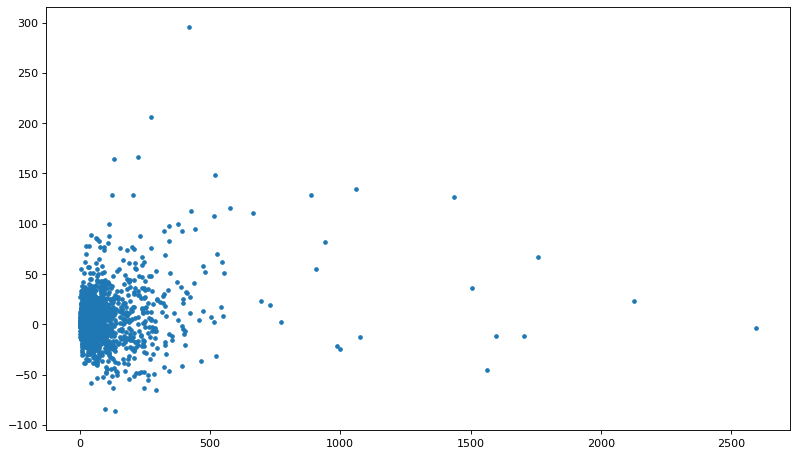

In [16]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [17]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,month,ticker,monthly_delta,monthly_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2,BKNG,9.877444,1.0,0.783088,0,Consumer Discretionary,Booking Holdings
169,2001,2,FFIV,2.805925,1.0,0.701299,1,Information Technology,"F5, Inc."
338,2001,2,AKAM,2.604197,1.0,0.448232,2,Information Technology,Akamai
507,2001,2,AMZN,1.739952,1.0,0.820000,3,Consumer Discretionary,Amazon
676,2001,2,VRSN,1.310289,1.0,0.568283,4,Information Technology,Verisign
845,2001,2,INCY,1.192500,1.0,0.764776,5,Health Care,Incyte
1014,2001,2,GLW,1.177330,1.0,0.798919,6,Information Technology,Corning Inc.
1183,2001,2,AAPL,1.102150,1.0,1.075369,7,Information Technology,Apple Inc.
1352,2001,2,NTAP,1.045339,1.0,0.553970,8,Information Technology,NetApp
1521,2001,2,TYL,0.995263,1.0,0.885714,9,Information Technology,Tyler Technologies


In [18]:
ledger.sort_values("actual_returns",ascending=False).head(50)

,year,month,ticker,monthly_delta,monthly_delta_sign,actual_returns,position,GICS Sector,Security
7,2001,10,EQIX,4.190951,1.0,3.959184,0,Real Estate,Equinix
1705,2002,10,AMT,2.727959,1.0,3.057851,10,Real Estate,American Tower
77,2009,8,AIG,2.242594,1.0,2.662722,0,Financials,American International Group
21,2003,5,REGN,1.307999,1.0,2.642643,0,Health Care,Regeneron
235,2008,7,AAL,5.196327,1.0,2.481481,1,Industrials,American Airlines Group
15,2002,10,SBAC,10.584678,1.0,2.344483,0,Real Estate,SBA Communications
3048,2002,10,AKAM,2.028718,1.0,2.287209,18,Information Technology,Akamai
1764,2009,4,FITB,1.249537,1.0,2.286111,10,Financials,Fifth Third Bank
408,2008,11,HIG,8.872420,1.0,2.282445,2,Financials,Hartford (The)
242,2009,3,LVS,14.366809,1.0,2.268722,1,Consumer Discretionary,Las Vegas Sands


In [19]:
ledger["actual_returns"].mean()

1.0351634466191082

In [20]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5862785862785863

In [21]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [22]:
portfolio.head(20)

position,year,month,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,2,0.783088,0.701299,0.448232,0.820000,0.568283,0.764776,0.798919,1.075369,...,0.731389,0.723704,0.701538,1.041765,0.773615,0.957956,0.934783,1.034923,0.963504,0.783397
1,2001,3,1.549296,1.018592,0.906667,1.043478,1.482188,1.613659,1.040902,1.148322,...,1.094775,1.129032,1.246175,1.265294,1.335949,1.076487,1.400669,1.269996,1.213494,1.157440
2,2001,4,1.071345,1.405751,1.930909,1.419660,0.899563,1.124850,1.167913,1.044820,...,1.187975,1.253606,0.982121,1.068571,1.323958,1.045234,1.035498,1.154902,1.233172,1.442953
3,2001,5,0.931223,0.742565,1.768182,0.844904,1.325800,1.014941,0.623706,1.047924,...,0.973007,1.097902,1.852459,1.098425,1.068382,1.068063,0.961373,0.997326,1.086163,0.860718
4,2001,7,1.213592,1.365830,1.029003,0.969856,1.148725,1.156187,1.188889,1.033994,...,0.678267,0.913725,1.178448,0.855856,1.096466,1.196345,0.980102,1.236462,0.743113,1.200000
5,2001,8,0.490734,0.520000,0.828269,0.510811,0.656597,0.931937,1.210526,0.772586,...,0.775966,0.854382,0.695701,0.665753,0.829280,0.994229,1.053507,0.935503,0.700116,0.792781
6,2001,9,1.129726,0.900000,0.534247,0.770867,0.660377,1.138508,0.944162,0.828871,...,1.150662,0.673012,0.890688,1.243496,1.058333,0.677992,0.805436,0.931073,0.829268,0.416797
7,2001,10,3.959184,1.830769,1.159259,1.169578,1.351852,1.051327,1.204433,1.476510,...,0.837887,1.063202,1.039671,1.264264,1.268027,1.213964,1.042904,1.188568,1.139409,1.129363
8,2001,11,0.939459,0.812929,0.886905,0.956890,0.730798,0.894737,1.098476,1.843750,...,0.886792,0.930044,1.095684,1.087324,0.843333,1.131884,1.040741,1.086966,0.964776,0.963316
9,2002,2,1.930526,1.057441,1.358537,1.114286,1.194915,1.136364,1.392159,1.305556,...,1.072252,1.163265,1.195316,1.153269,1.203081,1.283432,1.167123,1.284864,1.285036,0.907143


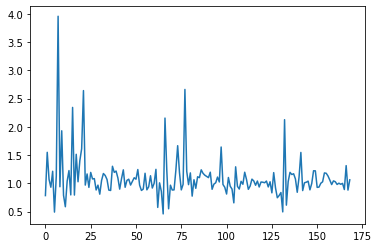

In [23]:
plt.plot(portfolio[0])

In [24]:
positions = ledger["position"].max()

In [25]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\reshape\merge.py:1214: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


In [26]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,year,month,pv,daily_returns,adjclose,bench,date
676,1524.962550,1535.586780,42.687495,0.748730,5.979360,30.228663,78.071949,6.583749,2.793274,32.514761,...,11.059102,16.463327,1.926381,2019,10,189.362292,1.058090,8163.19840,3.152167,2019-10-28
677,1342.447471,1607.445728,43.634210,0.736664,6.926158,32.132709,84.752685,7.012305,3.308091,34.062057,...,11.655637,19.568795,2.028620,2019,11,186.523510,1.082888,8437.66740,3.258151,2019-11-28
678,1342.447471,1607.445728,43.634210,0.736664,6.926158,32.132709,84.752685,7.012305,3.308091,34.062057,...,11.655637,19.568795,2.028620,2019,11,186.523510,1.082888,8490.46260,3.278538,2019-11-28
679,1342.447471,1607.445728,43.634210,0.736664,6.926158,32.132709,84.752685,7.012305,3.308091,34.062057,...,11.655637,19.568795,2.028620,2019,11,186.523510,1.082888,8534.68440,3.295614,2019-11-28
680,1342.447471,1607.445728,43.634210,0.736664,6.926158,32.132709,84.752685,7.012305,3.308091,34.062057,...,11.655637,19.568795,2.028620,2019,11,186.523510,1.082888,8662.76775,3.345073,2019-11-28
681,1425.658956,1496.804669,40.216722,0.833138,7.330719,27.150898,96.474790,8.157150,3.576549,33.259558,...,11.903095,19.995784,1.863505,2019,12,185.684783,1.014586,8959.29850,3.459576,2019-12-28
682,1425.658956,1496.804669,40.216722,0.833138,7.330719,27.150898,96.474790,8.157150,3.576549,33.259558,...,11.903095,19.995784,1.863505,2019,12,185.684783,1.014586,8576.50700,3.311763,2019-12-28
683,1425.658956,1496.804669,40.216722,0.833138,7.330719,27.150898,96.474790,8.157150,3.576549,33.259558,...,11.903095,19.995784,1.863505,2019,12,185.684783,1.014586,8668.85160,3.347422,2019-12-28
684,1425.658956,1496.804669,40.216722,0.833138,7.330719,27.150898,96.474790,8.157150,3.576549,33.259558,...,11.903095,19.995784,1.863505,2019,12,185.684783,1.014586,8855.49840,3.419494,2019-12-28
685,1425.658956,1496.804669,40.216722,0.833138,7.330719,27.150898,96.474790,8.157150,3.576549,33.259558,...,11.903095,19.995784,1.863505,2019,12,185.684783,1.014586,8981.88475,3.468298,2019-12-28


In [27]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [28]:
cash_analysis["cash"].sum()

3765.5926041882835

In [29]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,0.803307,NaN,NaN,0.000000,0.000000
1,0.803307,0.803307,0.645302,0.000000,0.000000
2,0.803307,0.803307,0.645302,0.000000,0.000000
3,1.238505,0.803307,0.994900,0.000000,0.000000
4,1.238505,1.000000,1.238505,23.850514,23.850514
...,...,...,...,...,...
681,1.014586,1.000000,1.014586,1.458644,3759.758029
682,1.014586,1.000000,1.014586,1.458644,3761.216673
683,1.014586,1.000000,1.014586,1.458644,3762.675317
684,1.014586,1.000000,1.014586,1.458644,3764.133960


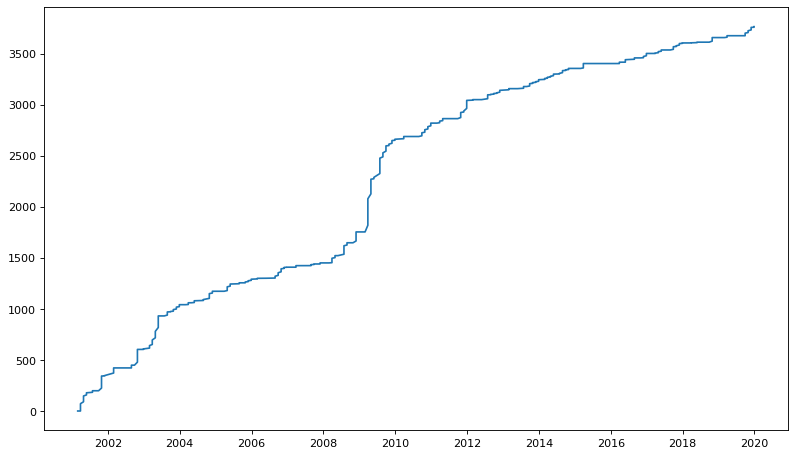

In [30]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

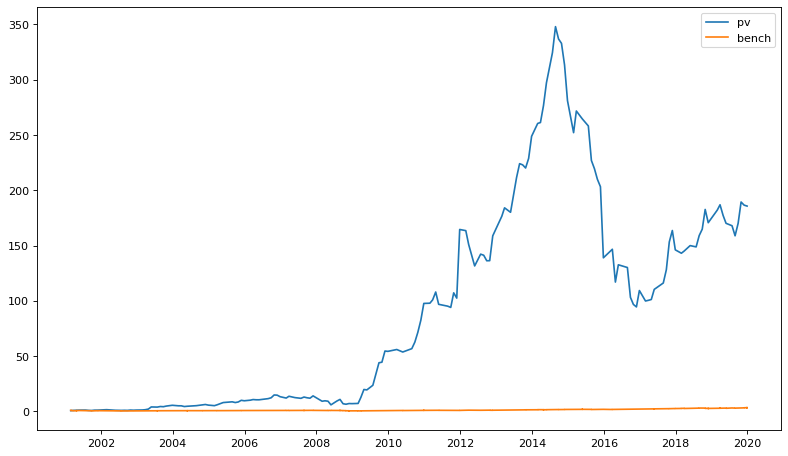

In [31]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [32]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,year,month,pv,daily_returns,adjclose,bench,date
0,0.783088,0.701299,0.448232,0.820000,0.568283,0.764776,0.798919,1.075369,0.553970,0.885714,...,0.934783,1.034923,0.963504,2001,2,0.803307,0.803307,2589.7100,1.000000,2001-02-28
1,0.783088,0.701299,0.448232,0.820000,0.568283,0.764776,0.798919,1.075369,0.553970,0.885714,...,0.934783,1.034923,0.963504,2001,2,0.803307,0.803307,2477.4140,0.956638,2001-02-28
2,0.783088,0.701299,0.448232,0.820000,0.568283,0.764776,0.798919,1.075369,0.553970,0.885714,...,0.934783,1.034923,0.963504,2001,2,0.803307,0.803307,2273.6900,0.877971,2001-02-28
3,1.213235,0.714337,0.406397,0.855652,0.842302,1.234088,0.831596,1.234869,0.972721,0.833203,...,1.309321,1.314348,1.169207,2001,3,0.989799,1.238505,2158.5560,0.833513,2001-03-28
4,1.213235,0.714337,0.406397,0.855652,0.842302,1.234088,0.831596,1.234869,0.972721,0.833203,...,1.309321,1.314348,1.169207,2001,3,0.989799,1.238505,1948.3740,0.752352,2001-03-28
5,1.213235,0.714337,0.406397,0.855652,0.842302,1.234088,0.831596,1.234869,0.972721,0.833203,...,1.309321,1.314348,1.169207,2001,3,0.989799,1.238505,1893.0460,0.730988,2001-03-28
6,1.213235,0.714337,0.406397,0.855652,0.842302,1.234088,0.831596,1.234869,0.972721,0.833203,...,1.309321,1.314348,1.169207,2001,3,0.989799,1.238505,1881.1420,0.726391,2001-03-28
7,1.299794,1.004180,0.784716,1.214735,0.757704,1.388163,0.971232,1.290216,1.288873,0.765371,...,1.355799,1.517943,1.441833,2001,4,1.145759,1.189129,1720.0260,0.664177,2001-04-28
8,1.299794,1.004180,0.784716,1.214735,0.757704,1.388163,0.971232,1.290216,1.288873,0.765371,...,1.355799,1.517943,1.441833,2001,4,1.145759,1.189129,1864.5300,0.719976,2001-04-28
9,1.299794,1.004180,0.784716,1.214735,0.757704,1.388163,0.971232,1.290216,1.288873,0.765371,...,1.355799,1.517943,1.441833,2001,4,1.145759,1.189129,2051.5560,0.792195,2001-04-28


In [33]:
# plt.figure(figsize=(12, 7), dpi=80)
# position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
# for i in position_columns:
#     position = cumulative[i]
#     plt.plot(cumulative["date"],position)
# plt.show()


In [34]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,month,monthly_delta,monthly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Financials,2009.125000,7.503676,1.165769,1.0,1.075709,10.496324
Real Estate,2008.918033,7.459016,0.864813,1.0,1.054289,9.923497
Industrials,2010.063291,7.411392,0.534122,1.0,1.050289,9.920886
Health Care,2008.380497,7.078394,0.352541,1.0,1.046850,9.388145
Consumer Staples,2011.035398,6.646018,0.182612,1.0,1.036073,10.884956
Consumer Discretionary,2011.625000,7.110915,0.521457,1.0,1.032095,9.186620
Communication Services,2010.951923,7.091346,0.428937,1.0,1.031221,8.615385
Utilities,2008.256637,6.646018,0.538836,1.0,1.030180,10.787611
Information Technology,2008.467572,6.892911,0.629133,1.0,1.018494,8.683258


In [35]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

,,,,monthly_delta,monthly_delta_sign,actual_returns,position
year,month,ticker,Security,,,,
2001,10,EQIX,Equinix,4.190951,1.0,3.959184,0
2002,10,AMT,American Tower,2.727959,1.0,3.057851,10
2009,8,AIG,American International Group,2.242594,1.0,2.662722,0
2003,5,REGN,Regeneron,1.307999,1.0,2.642643,0
2008,7,AAL,American Airlines Group,5.196327,1.0,2.481481,1
2002,10,AKAM,Akamai,5.004044,1.0,2.314118,216
2009,4,FITB,Fifth Third Bank,1.249537,1.0,2.286111,10
2008,11,HIG,Hartford (The),8.872420,1.0,2.282445,2
2009,3,LVS,Las Vegas Sands,14.366809,1.0,2.268722,1


In [36]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,month,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2,1.034923,0.801544,1.000000,1.000000,1.000000,0.903271,1.000000,0.773445,1.000000,1.000000,1.000000
1,4004001,6,1.034923,1.183145,1.000000,1.000000,1.000000,1.037245,1.000000,0.915042,1.000000,1.274721,1.000000
2,8012006001,24,1.034923,1.372150,1.000000,1.000000,1.000000,1.326735,1.000000,1.105784,1.000000,1.458985,1.000000
3,16032024008001,120,1.034923,1.782505,1.000000,1.000000,1.000000,1.937323,1.000000,1.081481,1.000000,1.255775,0.961373
4,32080080040010001,840,1.034923,1.324603,1.000000,1.000000,0.970616,2.104333,1.000000,1.227396,1.000000,1.175334,0.961373
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0,0,10.587209,21.417337,9.535255,1.697574,18.592215,186.438930,18.137186,3.456858,1.556350,20.399769,0.794611
165,0,0,10.587209,25.421571,10.003602,1.766547,18.592215,181.921811,18.137186,3.487668,1.700820,20.399769,0.794611
166,0,0,11.851004,26.290362,10.003602,1.775629,18.592215,214.183786,18.137186,4.021066,1.652711,20.399769,0.794611
167,0,0,12.485115,28.319444,10.003602,2.037008,18.592215,188.549208,18.137186,4.161332,1.770243,20.399769,0.794611
